In [1]:
# Instalar segment-anything y dependencias
!pip install -q segment-anything
!pip install -q opencv-python matplotlib torch torchvision
!pip install -q albumentations scikit-image

# Importar librerías
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from segment_anything.utils.transforms import ResizeLongestSide
import os
from sklearn.metrics import jaccard_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Librerías instaladas correctamente")

Using device: cuda
✅ Librerías instaladas correctamente


In [2]:
# Instalar Kaggle API
!pip install -q kaggle

# ===== OPCIÓN 1: Upload kaggle.json (RECOMENDADO PARA COLAB) =====
from google.colab import files
print("📁 Por favor, sube tu archivo kaggle.json")
uploaded = files.upload()

# Mover kaggle.json a la ubicación correcta
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configurada correctamente")

📁 Por favor, sube tu archivo kaggle.json


Saving kaggle.json to kaggle.json
✅ Kaggle API configurada correctamente


In [3]:
import os
import zipfile

# Verificar que kaggle esté configurado
try:
    # Intentar descargar dataset
    print("📥 Descargando dataset de Kaggle...")
    !kaggle datasets download -d faizalkarim/flood-area-segmentation
    print("✅ Dataset descargado")

except Exception as e:
    print(f"❌ Error al descargar: {e}")
    print("\n⚠️ SOLUCIONES:")
    print("1. Verifica que kaggle.json esté en ~/.kaggle/")
    print("2. Verifica permisos: !chmod 600 ~/.kaggle/kaggle.json")
    print("3. O descarga manualmente desde: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation")
    raise

# Descomprimir
zip_file = 'flood-area-segmentation.zip'

if os.path.exists(zip_file):
    print(f"📦 Descomprimiendo {zip_file}...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('flood_dataset')
    print("✅ Dataset descomprimido en flood_dataset/")

    # Limpiar zip
    os.remove(zip_file)
    print("🗑️ Archivo zip eliminado")
else:
    print(f"❌ No se encontró {zip_file}")
    print("⚠️ Descarga manualmente y sube el archivo a este entorno")

# Verificar estructura del dataset
print("\n📂 Estructura del dataset:")
for root, dirs, files in os.walk('flood_dataset'):
    level = root.replace('flood_dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Mostrar solo 3 archivos
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... y {len(files) - 3} archivos más')

print("\n✅ Dataset listo para usar!")

📥 Descargando dataset de Kaggle...
Dataset URL: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation
License(s): CC0-1.0
 94% 101M/107M [00:00<00:00, 964MB/s]
100% 107M/107M [00:00<00:00, 797MB/s]
✅ Dataset descargado
📦 Descomprimiendo flood-area-segmentation.zip...
✅ Dataset descomprimido en flood_dataset/
🗑️ Archivo zip eliminado

📂 Estructura del dataset:
flood_dataset/
  metadata.csv
  Mask/
    1083.png
    3.png
    1013.png
    ... y 287 archivos más
  Image/
    2012.jpg
    3068.jpg
    3050.jpg
    ... y 287 archivos más

✅ Dataset listo para usar!


In [4]:
# Primero, explorar la estructura para entender cómo está organizado
import os

print("📂 Explorando estructura del dataset...")
for root, dirs, files in os.walk('flood_dataset'):
    level = root.replace('flood_dataset', '').count(os.sep)
    if level < 3:  # Solo primeros 3 niveles
        indent = '  ' * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = '  ' * (level + 1)
        if files:
            for f in files[:3]:
                print(f'{subindent}{f}')
            if len(files) > 3:
                print(f'{subindent}... ({len(files)} total archivos)')

print("\n💡 Basándote en la estructura de arriba, identifica:")
print("   - ¿Dónde están las imágenes? (deberías ver carpeta 'Image')")
print("   - ¿Dónde están las máscaras? (deberías ver carpeta 'Mask')")

📂 Explorando estructura del dataset...
flood_dataset/
  metadata.csv
  Mask/
    1083.png
    3.png
    1013.png
    ... (290 total archivos)
  Image/
    2012.jpg
    3068.jpg
    3050.jpg
    ... (290 total archivos)

💡 Basándote en la estructura de arriba, identifica:
   - ¿Dónde están las imágenes? (deberías ver carpeta 'Image')
   - ¿Dónde están las máscaras? (deberías ver carpeta 'Mask')


📥 Cargando 100 imágenes...
  Cargadas 20/100...
  Cargadas 40/100...
  Cargadas 60/100...
  Cargadas 80/100...
  Cargadas 100/100...
✅ Cargadas 100 imágenes con sus máscaras
=== DATASET CARGADO ===
Total images: 100
Image shape (primera imagen): (551, 893, 3)
Mask shape (primera máscara): (551, 893)

📊 Estadísticas del dataset:
Tamaños únicos de imágenes: 81

Water pixel ratio (promedio): 42.80%
Background ratio: 57.20%


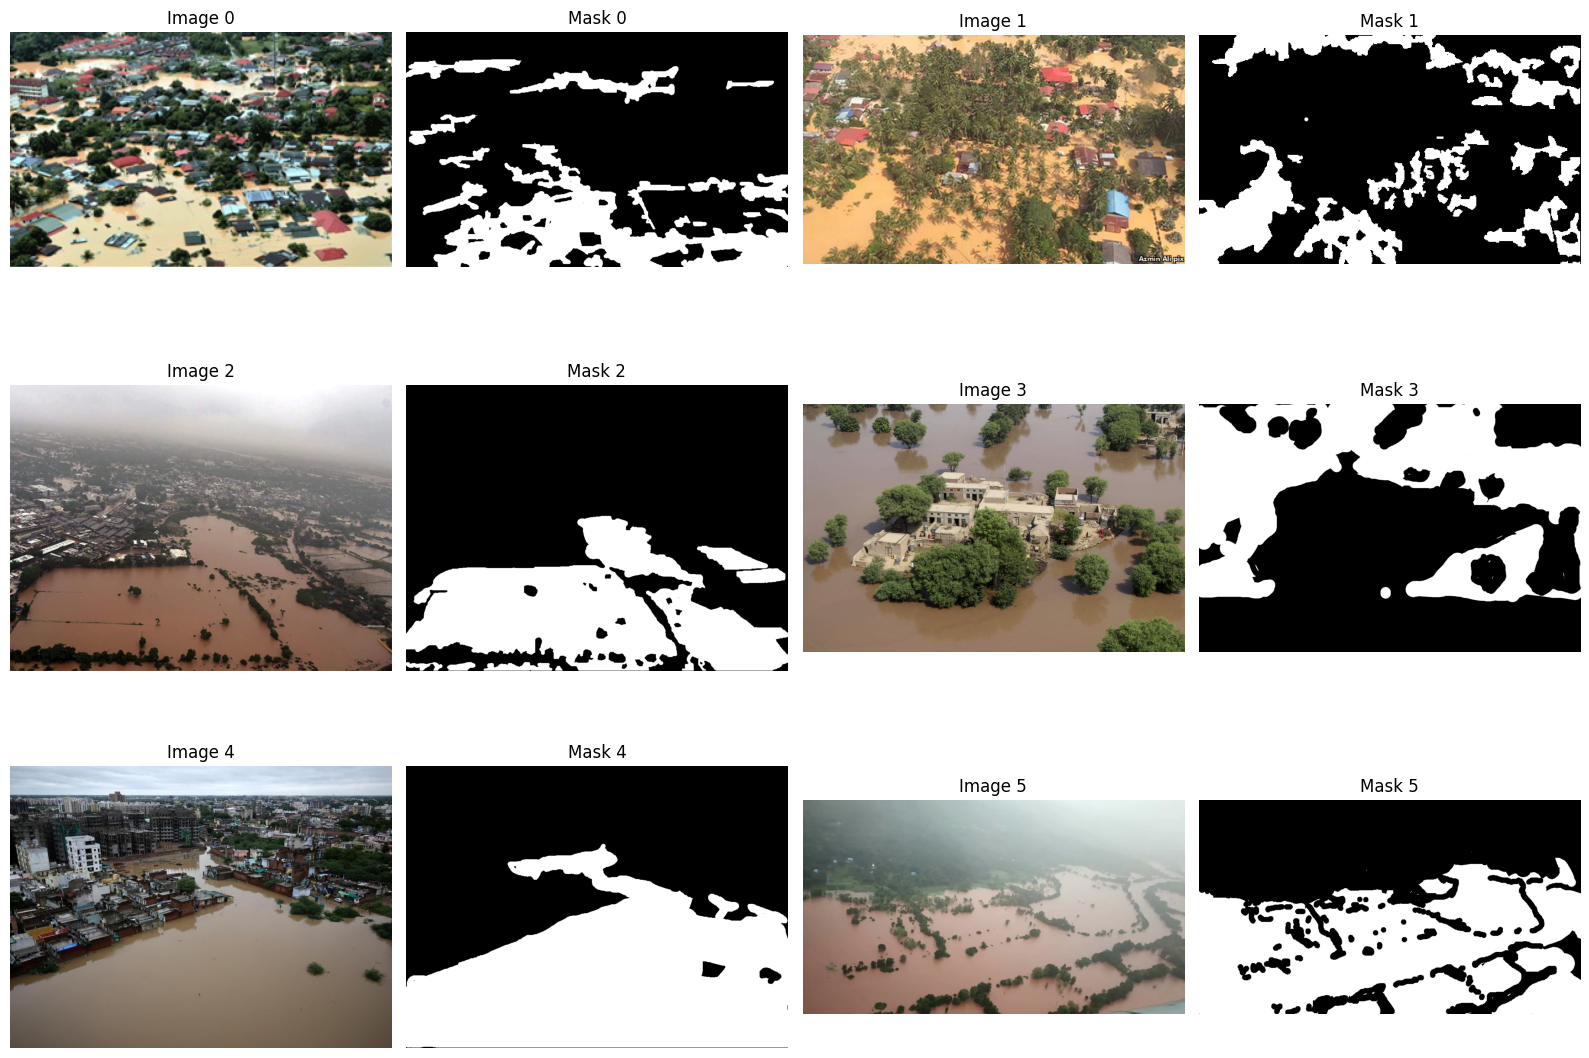

In [5]:
# Cargar y visualizar muestras del dataset

def load_flood_data(dataset_path='flood_dataset', max_samples=100):
    """
    Cargar imágenes y máscaras del dataset de flood segmentation

    Args:
        dataset_path: Path al dataset descargado
        max_samples: Número máximo de samples a cargar

    Returns:
        images: Lista de imágenes RGB
        masks: Lista de máscaras binarias
    """

    image_dir = os.path.join(dataset_path, 'Image')  # Completa: nombre de carpeta de imágenes
    mask_dir = os.path.join(dataset_path, 'Mask')   # Completa: nombre de carpeta de máscaras

    # Verificar que los directorios existen
    if not os.path.exists(image_dir):
        raise ValueError(f"❌ Directorio de imágenes no encontrado: {image_dir}")
    if not os.path.exists(mask_dir):
        raise ValueError(f"❌ Directorio de máscaras no encontrado: {mask_dir}")

    # Listar archivos
    image_files = sorted([f for f in os.listdir(image_dir)
                         if f.endswith(('.png', '.jpg', '.jpeg'))])[:max_samples]

    images = []
    masks = []

    print(f"📥 Cargando {len(image_files)} imágenes...")

    for i, img_file in enumerate(image_files):
        # Cargar imagen
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ No se pudo cargar: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Cargar mask
        # Intentar con mismo nombre pero diferentes extensiones
        base_name = os.path.splitext(img_file)[0]
        mask_file = None

        for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
            potential_mask = base_name + ext
            mask_path = os.path.join(mask_dir, potential_mask)
            if os.path.exists(mask_path):
                mask_file = potential_mask
                break

        if mask_file is None:
            print(f"⚠️ Mask no encontrada para: {img_file}")
            continue

        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"⚠️ No se pudo cargar mask: {mask_path}")
            continue

        # Binarizar mask (0 o 1)
        mask = (mask > 127).astype(np.uint8)

        images.append(img)
        masks.append(mask)

        if (i + 1) % 20 == 0:
            print(f"  Cargadas {i + 1}/{len(image_files)}...")

    print(f"✅ Cargadas {len(images)} imágenes con sus máscaras")

    if len(images) == 0:
        raise ValueError("❌ No se cargaron imágenes. Verifica los paths en la función.")

    return images, masks

# Cargar dataset
images, masks = load_flood_data(dataset_path='flood_dataset', max_samples=100)

print(f"=== DATASET CARGADO ===")
print(f"Total images: {len(images)}")
print(f"Image shape (primera imagen): {images[0].shape}")
print(f"Mask shape (primera máscara): {masks[0].shape}")

# Estadísticas - manejar imágenes de diferentes tamaños
print("\n📊 Estadísticas del dataset:")
image_sizes = [img.shape[:2] for img in images]
unique_sizes = set(image_sizes)
print(f"Tamaños únicos de imágenes: {len(unique_sizes)}")
if len(unique_sizes) <= 5:
    for size in unique_sizes:
        count = image_sizes.count(size)
        print(f"  {size}: {count} imágenes")

# Calcular ratio de agua considerando diferentes tamaños
total_water_pixels = sum(mask.sum() for mask in masks)
total_pixels = sum(mask.size for mask in masks)
water_ratio = total_water_pixels / total_pixels
print(f"\nWater pixel ratio (promedio): {water_ratio:.2%}")
print(f"Background ratio: {(1 - water_ratio):.2%}")

# Visualizar muestras
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(6):
    # Imagen original
    axes[i // 2, (i % 2) * 2].imshow(images[i])
    axes[i // 2, (i % 2) * 2].set_title(f'Image {i}')
    axes[i // 2, (i % 2) * 2].axis('off')

    # Mask
    axes[i // 2, (i % 2) * 2 + 1].imshow(masks[i], cmap='gray')
    axes[i // 2, (i % 2) * 2 + 1].set_title(f'Mask {i}')
    axes[i // 2, (i % 2) * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Descargar SAM checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Cargar modelo SAM
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ SAM model cargado: {model_type}")
print(f"   Device: {device}")

✅ SAM model cargado: vit_b
   Device: cuda


In [7]:
# Crear predictor para inference
predictor = SamPredictor(sam)
predictor.model.to(device)
print("✅ SAM Predictor creado")

✅ SAM Predictor creado


=== POINT PROMPT PREDICTION ===
Point: (1, 369)
Confidence score: 0.965


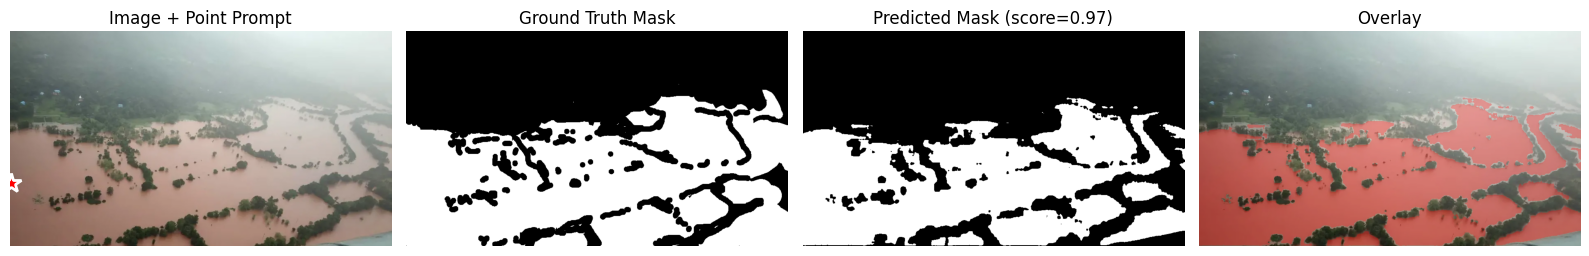

In [8]:
def predict_with_point_prompt(predictor, image, point_coords, point_labels):
    """
    Predict mask usando point prompts
    Args:
        predictor: SamPredictor instance
        image: RGB image [H, W, 3]
        point_coords: Points coordinates [[x1, y1], [x2, y2], ...]
        point_labels: Labels for points [1, 1, 0, ...] (1=foreground, 0=background)
    Returns:
        mask: Binary mask [H, W] - same size as input image
        score: Confidence score
    """
    # Set image for predictor
    predictor.set_image(image)

    # Predict with points
    masks, scores, logits = predictor.predict(
        point_coords=np.array(point_coords),
        point_labels=np.array(point_labels),
        multimask_output=True
    )

    # Select best mask
    best_mask_idx = np.argmax(scores)
    best_mask = masks[best_mask_idx]
    best_score = scores[best_mask_idx]

    # Resize mask to original image size if needed
    if best_mask.shape != image.shape[:2]:
        best_mask = cv2.resize(
            best_mask.astype(np.uint8),
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

    return best_mask, best_score

# Test con una imagen
test_idx = 5
test_image = images[test_idx]
test_mask_gt = masks[test_idx]

# Crear point prompt en el centro del área segmentada (agua)
H, W = test_mask_gt.shape
center_y, center_x = np.where(test_mask_gt > 0)

if len(center_x) > 0:
    point_x = int(center_x[len(center_x) // 2])
    point_y = int(center_y[len(center_y) // 2])
else:
    point_x, point_y = W // 2, H // 2

point_coords = [[point_x, point_y]]
point_labels = [1]  # Foreground

# Predict
pred_mask, score = predict_with_point_prompt(predictor, test_image, point_coords, point_labels)

print(f"=== POINT PROMPT PREDICTION ===")
print(f"Point: ({point_x}, {point_y})")
print(f"Confidence score: {score:.3f}")

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(test_image)
axes[0].plot(point_x, point_y, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=2)
axes[0].set_title('Image + Point Prompt')
axes[0].axis('off')

axes[1].imshow(test_mask_gt, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title(f'Predicted Mask (score={score:.2f})')
axes[2].axis('off')

# Overlay
overlay = test_image.copy()
overlay[pred_mask > 0] = [255, 0, 0]  # Rojo para predicción
axes[3].imshow(cv2.addWeighted(test_image, 0.7, overlay, 0.3, 0))
axes[3].set_title('Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.show()

=== BOX PROMPT PREDICTION ===
Box: [np.int64(0), np.int64(129), np.int64(928), np.int64(522)]
Confidence score: 0.989


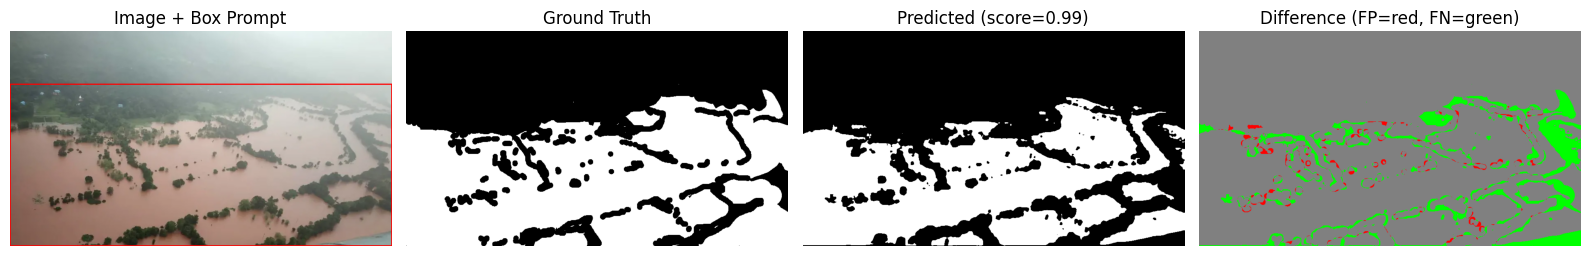

In [9]:
def predict_with_box_prompt(predictor, image, box):
    """
    Predict mask usando box prompt
    Args:
        predictor: SamPredictor instance
        image: RGB image [H, W, 3]
        box: Bounding box [x1, y1, x2, y2]
    Returns:
        mask: Binary mask [H, W] - same size as input image
        score: Confidence score
    """
    # Set image
    predictor.set_image(image)

    # Predict with box
    masks, scores, logits = predictor.predict(
        box=np.array(box),
        multimask_output=False  # Box es menos ambiguo
    )

    # Get first mask (best for box prompts)
    mask = masks[0]
    score = scores[0]

    # Resize mask to original image size if needed
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(
            mask.astype(np.uint8),
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

    return mask, score

# Crear box prompt desde ground truth (simulando un detector)
def get_bbox_from_mask(mask):
    """Extract bounding box from mask"""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if not rows.any() or not cols.any():
        return None
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return [x1, y1, x2, y2]

test_box = get_bbox_from_mask(test_mask_gt)

if test_box is not None:
    pred_mask_box, score_box = predict_with_box_prompt(predictor, test_image, test_box)

    print(f"=== BOX PROMPT PREDICTION ===")
    print(f"Box: {test_box}")
    print(f"Confidence score: {score_box:.3f}")

    # Visualizar
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Image + box
    img_with_box = test_image.copy()
    x1, y1, x2, y2 = test_box
    cv2.rectangle(img_with_box, (x1, y1), (x2, y2), (255, 0, 0), 2)
    axes[0].imshow(img_with_box)
    axes[0].set_title('Image + Box Prompt')
    axes[0].axis('off')

    axes[1].imshow(test_mask_gt, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(pred_mask_box, cmap='gray')
    axes[2].set_title(f'Predicted (score={score_box:.2f})')
    axes[2].axis('off')

    # Comparación
    diff = (pred_mask_box.astype(int) - test_mask_gt.astype(int))
    diff_vis = np.zeros((*diff.shape, 3), dtype=np.uint8)
    diff_vis[diff > 0] = [255, 0, 0]  # False positives = rojo
    diff_vis[diff < 0] = [0, 255, 0]  # False negatives = verde
    diff_vis[diff == 0] = [128, 128, 128]  # Correcto = gris

    axes[3].imshow(diff_vis)
    axes[3].set_title('Difference (FP=red, FN=green)')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
def calculate_iou(pred_mask, gt_mask):
    """
    Calculate IoU (Intersection over Union)

    Automáticamente redimensiona pred_mask si los tamaños no coinciden.
    """
    # Verificar y ajustar tamaños si no coinciden
    if pred_mask.shape != gt_mask.shape:
        pred_mask = cv2.resize(
            pred_mask.astype(np.uint8),
            (gt_mask.shape[1], gt_mask.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

    # Asegurar que ambas máscaras sean booleanas para operaciones bitwise
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)

    intersection = (pred_mask & gt_mask).sum()
    union = (pred_mask | gt_mask).sum()

    if union == 0:
        return 0.0

    return intersection / union

def calculate_dice(pred_mask, gt_mask):
    """
    Calculate Dice coefficient

    Automáticamente redimensiona pred_mask si los tamaños no coinciden.
    """
    # Verificar y ajustar tamaños si no coinciden
    if pred_mask.shape != gt_mask.shape:
        pred_mask = cv2.resize(
            pred_mask.astype(np.uint8),
            (gt_mask.shape[1], gt_mask.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

    # Asegurar que ambas máscaras sean booleanas para operaciones bitwise
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)

    intersection = (pred_mask & gt_mask).sum()

    if pred_mask.sum() + gt_mask.sum() == 0:
        return 1.0 if intersection == 0 else 0.0

    return 2 * intersection / (pred_mask.sum() + gt_mask.sum())

def calculate_precision_recall(pred_mask, gt_mask):
    """
    Calculate pixel-wise precision and recall

    Automáticamente redimensiona pred_mask si los tamaños no coinciden.
    """
    # Verificar y ajustar tamaños si no coinciden
    if pred_mask.shape != gt_mask.shape:
        pred_mask = cv2.resize(
            pred_mask.astype(np.uint8),
            (gt_mask.shape[1], gt_mask.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

    # Asegurar que ambas máscaras sean booleanas para operaciones bitwise
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)

    tp = (pred_mask & gt_mask).sum()
    fp = (pred_mask & ~gt_mask).sum()
    fn = (~pred_mask & gt_mask).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Evaluar predicciones
# Nota: Las funciones de métricas manejan automáticamente diferentes tamaños
# y convierten las máscaras a booleanas para operaciones bitwise
iou_point = calculate_iou(pred_mask, test_mask_gt)
dice_point = calculate_dice(pred_mask, test_mask_gt)
prec_point, rec_point = calculate_precision_recall(pred_mask, test_mask_gt)

print(f"=== MÉTRICAS - POINT PROMPT ===")
print(f"IoU: {iou_point:.4f}")
print(f"Dice: {dice_point:.4f}")
print(f"Precision: {prec_point:.4f}")
print(f"Recall: {rec_point:.4f}")

if test_box is not None:
    iou_box = calculate_iou(pred_mask_box, test_mask_gt)
    dice_box = calculate_dice(pred_mask_box, test_mask_gt)
    prec_box, rec_box = calculate_precision_recall(pred_mask_box, test_mask_gt)

    print(f"\n=== MÉTRICAS - BOX PROMPT ===")
    print(f"IoU: {iou_box:.4f}")
    print(f"Dice: {dice_box:.4f}")
    print(f"Precision: {prec_box:.4f}")
    print(f"Recall: {rec_box:.4f}")

    print(f"\n=== COMPARACIÓN ===")
    print(f"Box prompt better: {iou_box > iou_point}")

=== MÉTRICAS - POINT PROMPT ===
IoU: 0.8070
Dice: 0.8932
Precision: 0.9681
Recall: 0.8290

=== MÉTRICAS - BOX PROMPT ===
IoU: 0.8016
Dice: 0.8899
Precision: 0.9756
Recall: 0.8180

=== COMPARACIÓN ===
Box prompt better: False


=== EVALUATING PRETRAINED SAM (Point Prompts) ===
  Processed 20/100 images...
  Processed 40/100 images...
  Processed 60/100 images...
  Processed 80/100 images...
  Processed 100/100 images...

=== PRETRAINED SAM - POINT PROMPTS ===
Mean IoU: 0.5291 ± 0.3214
Mean Dice: 0.6220 ± 0.3377
Mean Precision: 0.8193
Mean Recall: 0.5885

=== EVALUATING PRETRAINED SAM (Box Prompts) ===
  Processed 20/100 images...
  Processed 40/100 images...
  Processed 60/100 images...
  Processed 80/100 images...
  Processed 100/100 images...

=== PRETRAINED SAM - BOX PROMPTS ===
Mean IoU: 0.7230 ± 0.2088
Mean Dice: 0.8156 ± 0.1985
Mean Precision: 0.8476
Mean Recall: 0.8106


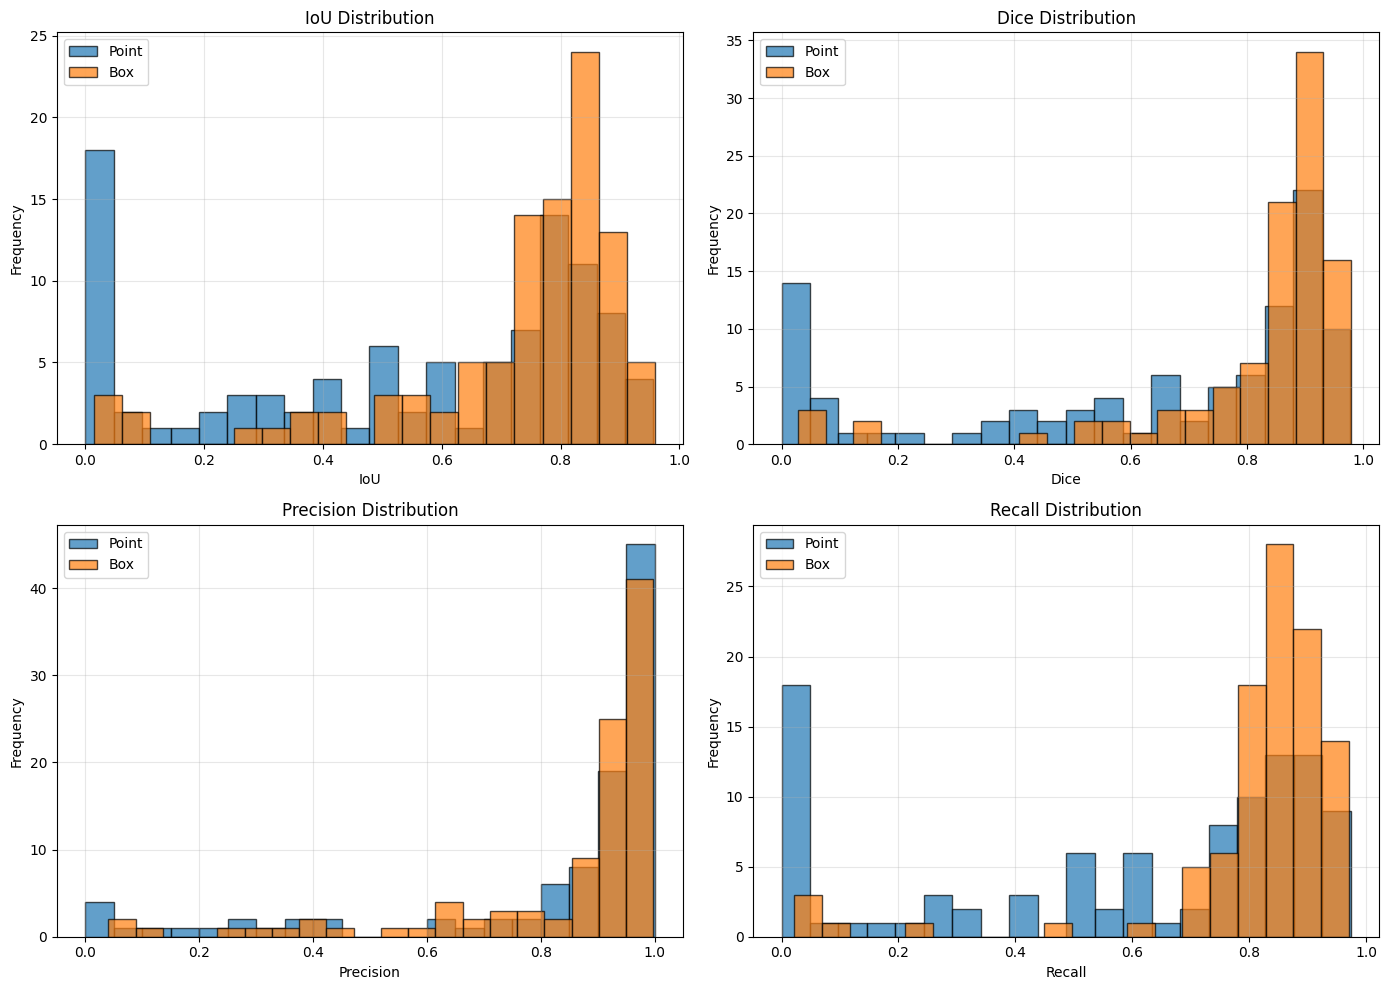

In [11]:
# Evaluar SAM pretrained en todas las imágenes

def evaluate_pretrained_sam(images, masks, predictor, prompt_type='point'):
    """
    Evaluar SAM pretrained en dataset completo

    Args:
        images: List of images
        masks: List of ground truth masks
        predictor: SamPredictor
        prompt_type: 'point' or 'box'

    Returns:
        results: Dictionary con métricas
    """

    results = {
        'iou': [],
        'dice': [],
        'precision': [],
        'recall': []
    }

    for i, (image, mask_gt) in enumerate(zip(images, masks)):

        if prompt_type == 'point':
            # Get center point del área de agua
            y_coords, x_coords = np.where(mask_gt > 0)
            if len(x_coords) == 0:
                continue

            point_x = int(x_coords[len(x_coords) // 2])
            point_y = int(y_coords[len(y_coords) // 2])

            pred_mask, _ = predict_with_point_prompt(
                predictor, image, [[point_x, point_y]], [1]
            )

        elif prompt_type == 'box':
            box = get_bbox_from_mask(mask_gt)
            if box is None:
                continue

            pred_mask, _ = predict_with_box_prompt(predictor, image, box)

        # Calcular métricas
        iou = calculate_iou(pred_mask, mask_gt)
        dice = calculate_dice(pred_mask, mask_gt)
        prec, rec = calculate_precision_recall(pred_mask, mask_gt)

        results['iou'].append(iou)
        results['dice'].append(dice)
        results['precision'].append(prec)
        results['recall'].append(rec)

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(images)} images...")

    # Calcular promedios
    for key in results:
        results[key] = np.array(results[key])

    return results

# Evaluar con point prompts
print("=== EVALUATING PRETRAINED SAM (Point Prompts) ===")
results_pretrained_point = evaluate_pretrained_sam(images, masks, predictor, prompt_type='point')

print(f"\n=== PRETRAINED SAM - POINT PROMPTS ===")
print(f"Mean IoU: {results_pretrained_point['iou'].mean():.4f} ± {results_pretrained_point['iou'].std():.4f}")
print(f"Mean Dice: {results_pretrained_point['dice'].mean():.4f} ± {results_pretrained_point['dice'].std():.4f}")
print(f"Mean Precision: {results_pretrained_point['precision'].mean():.4f}")
print(f"Mean Recall: {results_pretrained_point['recall'].mean():.4f}")

# Evaluar con box prompts
print("\n=== EVALUATING PRETRAINED SAM (Box Prompts) ===")
results_pretrained_box = evaluate_pretrained_sam(images, masks, predictor, prompt_type='box')

print(f"\n=== PRETRAINED SAM - BOX PROMPTS ===")
print(f"Mean IoU: {results_pretrained_box['iou'].mean():.4f} ± {results_pretrained_box['iou'].std():.4f}")
print(f"Mean Dice: {results_pretrained_box['dice'].mean():.4f} ± {results_pretrained_box['dice'].std():.4f}")
print(f"Mean Precision: {results_pretrained_box['precision'].mean():.4f}")
print(f"Mean Recall: {results_pretrained_box['recall'].mean():.4f}")

# Visualizar distribución de métricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(results_pretrained_point['iou'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[0, 0].hist(results_pretrained_box['iou'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[0, 0].set_xlabel('IoU')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('IoU Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(results_pretrained_point['dice'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[0, 1].hist(results_pretrained_box['dice'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[0, 1].set_xlabel('Dice')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Dice Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(results_pretrained_point['precision'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[1, 0].hist(results_pretrained_box['precision'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Precision Distribution')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(results_pretrained_point['recall'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[1, 1].hist(results_pretrained_box['recall'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Recall Distribution')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
class FloodSegmentationDataset(Dataset):
    """
    PyTorch Dataset para flood water segmentation
    IMPORTANTE: Redimensiona todas las imágenes a un tamaño fijo (1024x1024)
    que es el tamaño nativo de SAM para poder hacer batching en DataLoader.
    """
    def __init__(self, images, masks, transform=None, prompt_type='point', image_size=1024):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.prompt_type = prompt_type
        self.image_size = image_size  # Tamaño fijo: 1024x1024 (nativo de SAM)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()

        # Guardar tamaño original antes de transformaciones
        original_size = image.shape[:2]

        # IMPORTANTE: Resize PRIMERO a tamaño fijo para que Albumentations funcione
        # (Albumentations requiere que image y mask tengan el mismo tamaño)
        image_resized = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        # Apply augmentations DESPUÉS del resize (ahora ambas son 1024x1024)
        if self.transform:
            augmented = self.transform(image=image_resized, mask=mask_resized)
            image_resized = augmented['image']
            mask_resized = augmented['mask']

        # Convert to torch tensors
        image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).to(torch.float32) / 255.0
        mask_tensor = torch.from_numpy(mask_resized).unsqueeze(0).float()

        # Generate prompt (usando mask_resized para coordenadas correctas)
        if self.prompt_type == 'point':
            # Sample random point from water region
            y_coords, x_coords = np.where(mask_resized > 0)
            if len(x_coords) > 0:
                rand_idx = np.random.randint(len(x_coords))
                point = np.array([[x_coords[rand_idx], y_coords[rand_idx]]])
                label = np.array([1])
            else:
                # Fallback si no hay agua en la imagen
                point = np.array([[self.image_size // 2, self.image_size // 2]])
                label = np.array([0])
            prompt = {'points': point, 'labels': label, 'boxes': None}

        elif self.prompt_type == 'box':
            box = get_bbox_from_mask(mask_resized)
            if box is None:
                box = [0, 0, self.image_size, self.image_size]
            prompt = {'points': None, 'labels': None, 'boxes': np.array([box])}

        return {
            'image': image_tensor,
            'mask': mask_tensor,
            'original_size': original_size,  # Tamaño antes de cualquier transformación
            'prompt': prompt
        }

# Crear train/val split
train_size = int(0.8 * len(images))
train_images, val_images = images[:train_size], images[train_size:]
train_masks, val_masks = masks[:train_size], masks[train_size:]

print(f"=== DATA SPLIT ===")
print(f"Train: {len(train_images)} images")
print(f"Val: {len(val_images)} images")

# Augmentations para training
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
])

# Crear datasets
train_dataset = FloodSegmentationDataset(train_images, train_masks, transform=train_transform, prompt_type='point')
val_dataset = FloodSegmentationDataset(val_images, val_masks, transform=None, prompt_type='point')

print(f"✅ Datasets creados")

=== DATA SPLIT ===
Train: 80 images
Val: 20 images
✅ Datasets creados


In [13]:
# Crear DataLoaders
def collate_fn(batch):
    """
    Custom collate function para manejar prompts variables
    torch.stack() requiere que todos los tensores tengan el mismo tamaño.
    Esto funciona porque FloodSegmentationDataset redimensiona todas las
    imágenes y máscaras a 1024x1024 (tamaño nativo de SAM).
    """
    return {
        'images': torch.stack([item['image'] for item in batch]),
        'masks': torch.stack([item['mask'] for item in batch]),
        'prompts': [item['prompt'] for item in batch],
        'original_sizes': [item['original_size'] for item in batch]
    }

batch_size = 2
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn
)

print(f"=== DATALOADERS CREADOS ===")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Verificar un batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Images shape: {sample_batch['images'].shape}")
print(f"  Masks shape: {sample_batch['masks'].shape}")
print(f"  Prompts: {len(sample_batch['prompts'])} items")

=== DATALOADERS CREADOS ===
Train batches: 40
Val batches: 10

Sample batch:
  Images shape: torch.Size([2, 3, 1024, 1024])
  Masks shape: torch.Size([2, 1, 1024, 1024])
  Prompts: 2 items


In [14]:
def dice_loss(pred, target, smooth=1.0):
    """
    Dice loss para binary segmentation
    Args:
        pred: Predicted masks (logits) [B, 1, H, W]
        target: Ground truth masks (binary) [B, 1, H, W]
        smooth: Smoothing factor para evitar división por cero
    Returns:
        loss: Dice loss escalar
    """
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Flatten tensors
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    # Calculate intersection and union
    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / \
           (pred_flat.sum() + target_flat.sum() + smooth)

    return 1 - dice

def combined_loss(pred, target, bce_weight=0.5):
    """
    Combined BCE + Dice loss
    Args:
        pred: Predicted masks (logits) [B, 1, H, W]
        target: Ground truth masks [B, 1, H, W]
        bce_weight: Weight for BCE loss (1 - bce_weight for Dice)
    Returns:
        loss: Combined loss
    """
    # Binary Cross Entropy
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='mean')

    # Dice Loss
    dice = dice_loss(pred, target)

    # Combined
    return bce_weight * bce + (1 - bce_weight) * dice

print("✅ Loss functions definidas")

# Test loss function
test_pred = torch.randn(2, 1, 256, 256)  # Fake logits
test_target = torch.randint(0, 2, (2, 1, 256, 256)).float()
test_loss = combined_loss(test_pred, test_target)
print(f"Test loss: {test_loss.item():.4f}")

✅ Loss functions definidas
Test loss: 0.6532


In [15]:
# Preparar modelo para fine-tuning

# Cargar modelo fresco
sam_finetune = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_finetune.to(device)

# Freeze image encoder (recomendado para eficiencia)
for param in sam_finetune.image_encoder.parameters():
    param.requires_grad = False

# Train solo mask decoder
for param in sam_finetune.mask_decoder.parameters():
    param.requires_grad = True

# Freeze prompt encoder también
for param in sam_finetune.prompt_encoder.parameters():
    param.requires_grad = False

# Contar parámetros trainables
total_params = sum(p.numel() for p in sam_finetune.parameters())
trainable_params = sum(p.numel() for p in sam_finetune.parameters() if p.requires_grad)

print(f"=== FINE-TUNING SETUP ===")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

# Setup optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    [p for p in sam_finetune.parameters() if p.requires_grad],
    lr=learning_rate
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"\nOptimizer: Adam")
print(f"Learning rate: {learning_rate}")
print(f"Scheduler: StepLR (decay every 5 epochs by 0.5)")

=== FINE-TUNING SETUP ===
Total parameters: 93,735,472
Trainable parameters: 4,058,340
Trainable %: 4.33%

Optimizer: Adam
Learning rate: 0.0001
Scheduler: StepLR (decay every 5 epochs by 0.5)


In [16]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    """
    Train por un epoch
    """
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    n_batches = 0

    for batch in dataloader:
        images = batch['images'].to(device)
        masks_gt = batch['masks'].to(device)
        prompts = batch['prompts']

        # Process each image individually to avoid batch dimension mismatch
        # SAM's architecture expects one image-prompt pair at a time during training
        batch_size_actual = images.shape[0]

        for i in range(batch_size_actual):
            # Get single image and mask
            image = images[i:i+1]  # Keep batch dimension [1, C, H, W]
            mask = masks_gt[i:i+1]  # Keep batch dimension [1, 1, H, W]
            prompt = prompts[i]

            # Forward pass
            with torch.no_grad():
                # Image encoding (frozen)
                image_embedding = model.image_encoder(image)

            # Process prompt
            if prompt['points'] is not None:
                points = (
                    torch.from_numpy(prompt['points']).float().unsqueeze(0).to(device),
                    torch.from_numpy(prompt['labels']).float().unsqueeze(0).to(device)
                )
                sparse_emb, dense_emb = model.prompt_encoder(
                    points=points,
                    boxes=None,
                    masks=None
                )
            else:
                boxes = torch.from_numpy(prompt['boxes']).float().unsqueeze(0).to(device)
                sparse_emb, dense_emb = model.prompt_encoder(
                    points=None,
                    boxes=boxes,
                    masks=None
                )

            # Mask decoding (trainable)
            mask_pred, iou_pred = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_emb,
                dense_prompt_embeddings=dense_emb,
                multimask_output=False
            )

            # Resize ground truth mask to match SAM output size (256x256)
            # SAM's mask decoder outputs 256x256 masks regardless of input size
            mask_resized = F.interpolate(mask, size=(256, 256), mode='bilinear', align_corners=False)

            # Calculate loss
            loss = loss_fn(mask_pred, mask_resized)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics (resize prediction back to original size for accurate evaluation)
            with torch.no_grad():
                pred_binary = (torch.sigmoid(mask_pred) > 0.5).float()
                # Resize prediction to original mask size (1024x1024) for IoU calculation
                pred_binary_full = F.interpolate(pred_binary, size=(1024, 1024), mode='nearest')
                iou = calculate_iou(
                    pred_binary_full.cpu().numpy()[0, 0],
                    mask.cpu().numpy()[0, 0]
                )

            epoch_loss += loss.item()
            epoch_iou += iou
            n_batches += 1

    return epoch_loss / n_batches, epoch_iou / n_batches

def validate(model, dataloader, loss_fn, device):
    """
    Validar modelo
    """
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['images'].to(device)
            masks_gt = batch['masks'].to(device)
            prompts = batch['prompts']

            # Process each image individually (same as training)
            batch_size_actual = images.shape[0]

            for i in range(batch_size_actual):
                # Get single image and mask
                image = images[i:i+1]
                mask = masks_gt[i:i+1]
                prompt = prompts[i]

                # Forward
                image_embedding = model.image_encoder(image)

                # Process prompt
                if prompt['points'] is not None:
                    points = (
                        torch.from_numpy(prompt['points']).float().unsqueeze(0).to(device),
                        torch.from_numpy(prompt['labels']).float().unsqueeze(0).to(device)
                    )
                    sparse_emb, dense_emb = model.prompt_encoder(
                        points=points, boxes=None, masks=None
                    )
                else:
                    boxes = torch.from_numpy(prompt['boxes']).float().unsqueeze(0).to(device)
                    sparse_emb, dense_emb = model.prompt_encoder(
                        points=None, boxes=boxes, masks=None
                    )

                mask_pred, _ = model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_emb,
                    dense_prompt_embeddings=dense_emb,
                    multimask_output=False
                )

                # Resize ground truth mask to match SAM output size (256x256)
                mask_resized = F.interpolate(mask, size=(256, 256), mode='bilinear', align_corners=False)

                loss = loss_fn(mask_pred, mask_resized)

                pred_binary = (torch.sigmoid(mask_pred) > 0.5).float()
                # Resize prediction to original mask size (1024x1024) for IoU calculation
                pred_binary_full = F.interpolate(pred_binary, size=(1024, 1024), mode='nearest')
                iou = calculate_iou(
                    pred_binary_full.cpu().numpy()[0, 0],
                    mask.cpu().numpy()[0, 0]
                )

                val_loss += loss.item()
                val_iou += iou
                n_batches += 1

    return val_loss / n_batches, val_iou / n_batches

print("✅ Training functions definidas")

✅ Training functions definidas


=== STARTING TRAINING ===
Epochs: 15
Batch size: 2
Learning rate: 0.0001

Epoch 1/15
--------------------------------------------------
Train Loss: 0.4673 | Train IoU: 0.5372
Val Loss: 0.4267 | Val IoU: 0.6272
✅ Best model saved! (Val IoU: 0.6272)

Epoch 2/15
--------------------------------------------------
Train Loss: 0.3373 | Train IoU: 0.6477
Val Loss: 0.3995 | Val IoU: 0.5810

Epoch 3/15
--------------------------------------------------
Train Loss: 0.3324 | Train IoU: 0.6407
Val Loss: 0.3241 | Val IoU: 0.7336
✅ Best model saved! (Val IoU: 0.7336)

Epoch 4/15
--------------------------------------------------
Train Loss: 0.3384 | Train IoU: 0.6424
Val Loss: 0.3094 | Val IoU: 0.7076

Epoch 5/15
--------------------------------------------------
Train Loss: 0.2824 | Train IoU: 0.6930
Val Loss: 0.3178 | Val IoU: 0.6938

Epoch 6/15
--------------------------------------------------
Train Loss: 0.2858 | Train IoU: 0.6905
Val Loss: 0.2840 | Val IoU: 0.7389
✅ Best model saved! (Val IoU:

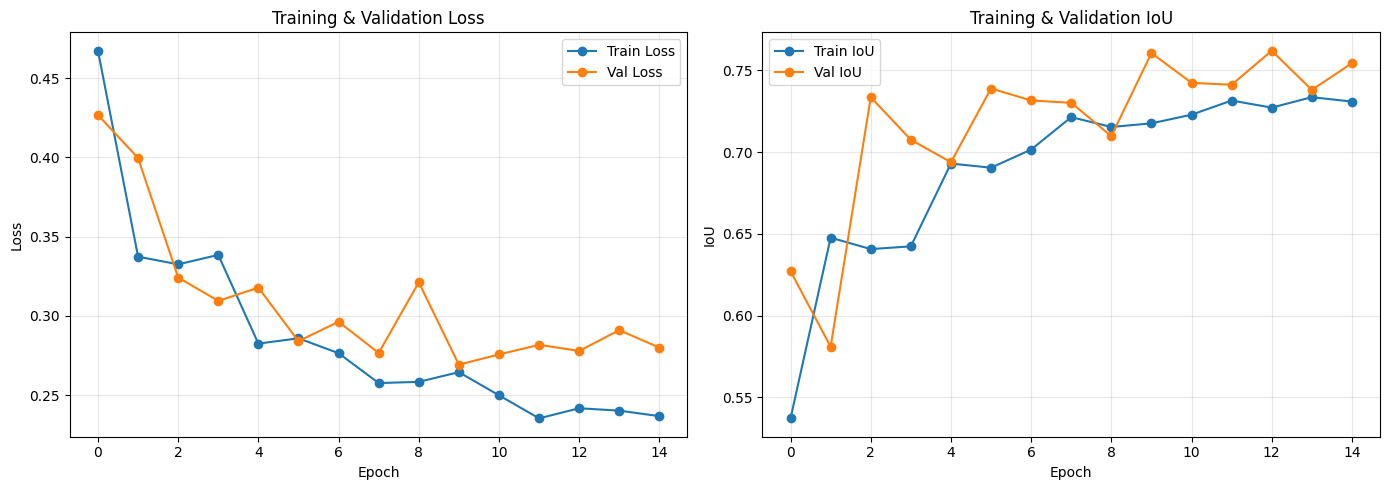

In [17]:
# Entrenar modelo

num_epochs = 15

best_val_iou = 0.0

history = {
    'train_loss': [],
    'train_iou': [],
    'val_loss': [],
    'val_iou': []
}

print("=== STARTING TRAINING ===")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_iou = train_epoch(
        sam_finetune, train_loader, optimizer, combined_loss, device
    )

    # Validate
    val_loss, val_iou = validate(
        sam_finetune, val_loader, combined_loss, device
    )

    # Scheduler step
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)

    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(sam_finetune.state_dict(), 'sam_finetuned_best.pth')
        print(f"✅ Best model saved! (Val IoU: {best_val_iou:.4f})")

print("\n=== TRAINING COMPLETED ===")
print(f"Best Val IoU: {best_val_iou:.4f}")

# Visualizar training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# IoU
axes[1].plot(history['train_iou'], label='Train IoU', marker='o')
axes[1].plot(history['val_iou'], label='Val IoU', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training & Validation IoU')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Cargar best checkpoint

sam_finetuned = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_finetuned.load_state_dict(torch.load('sam_finetuned_best.pth', map_location=device))
sam_finetuned.to(device)
sam_finetuned.eval()

print("✅ Fine-tuned model cargado")

# Crear predictor para fine-tuned model
predictor_finetuned = SamPredictor(sam_finetuned)

✅ Fine-tuned model cargado


=== EVALUATING FINE-TUNED SAM ===
  Processed 20/20 images...

=== FINE-TUNED SAM ===
Mean IoU: 0.7497 ± 0.1998
Mean Dice: 0.8375 ± 0.1719
Mean Precision: 0.8839
Mean Recall: 0.8087

=== COMPARISON ===
Metric          Pretrained      Fine-tuned      Improvement    
------------------------------------------------------------
IOU             0.5291          0.7497          41.68          %
DICE            0.6220          0.8375          34.65          %
PRECISION       0.8193          0.8839          7.89           %
RECALL          0.5885          0.8087          37.41          %


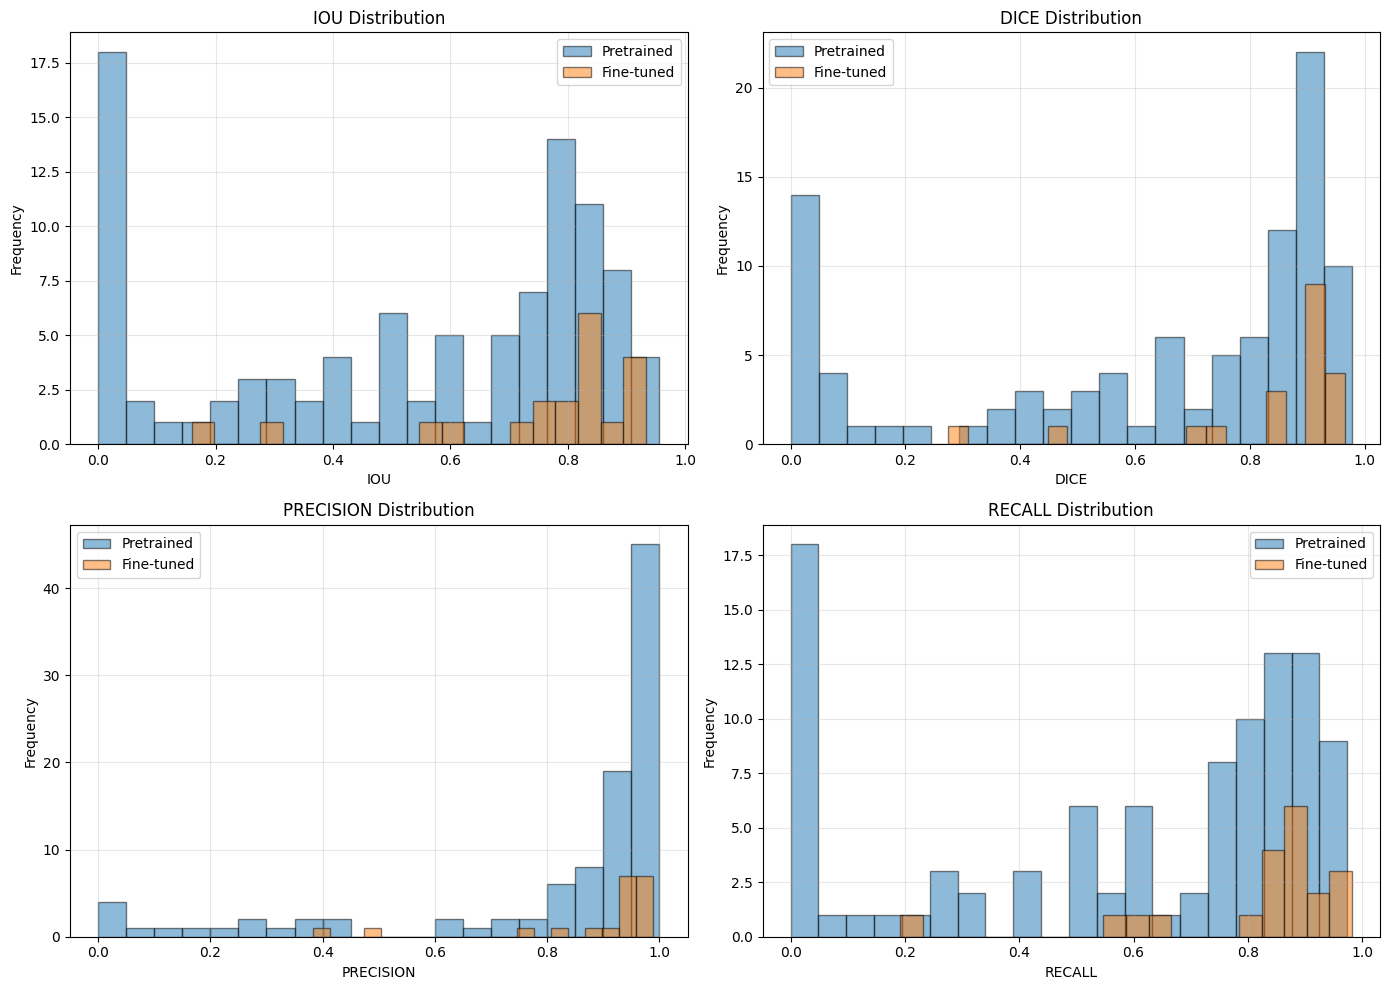

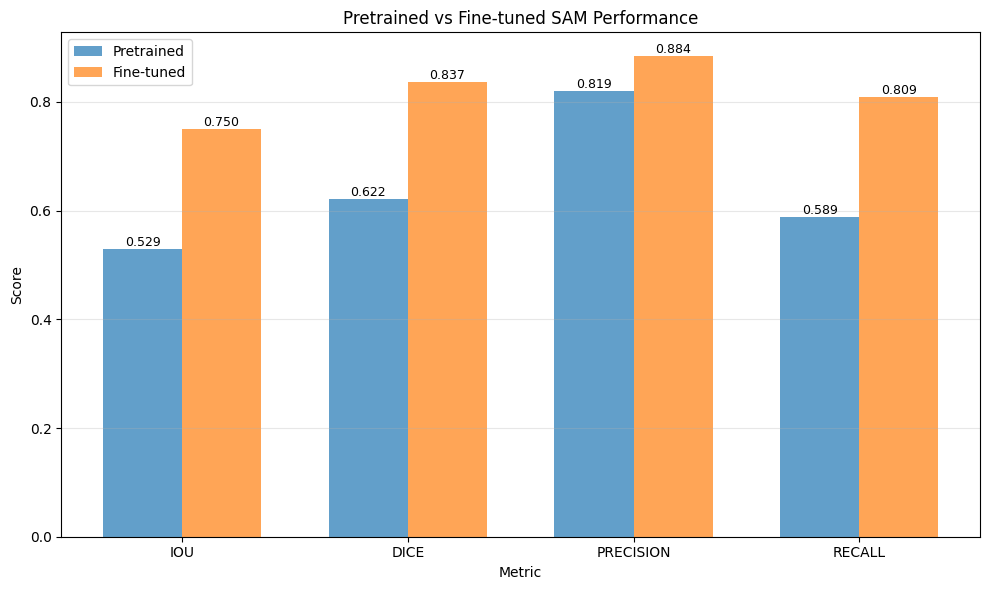

In [19]:
# Evaluar fine-tuned model en test set

print("=== EVALUATING FINE-TUNED SAM ===")
results_finetuned = evaluate_pretrained_sam(val_images, val_masks, predictor_finetuned, prompt_type='point')

print(f"\n=== FINE-TUNED SAM ===")
print(f"Mean IoU: {results_finetuned['iou'].mean():.4f} ± {results_finetuned['iou'].std():.4f}")
print(f"Mean Dice: {results_finetuned['dice'].mean():.4f} ± {results_finetuned['dice'].std():.4f}")
print(f"Mean Precision: {results_finetuned['precision'].mean():.4f}")
print(f"Mean Recall: {results_finetuned['recall'].mean():.4f}")

# Comparación
print("\n=== COMPARISON ===")
print(f"{'Metric':<15} {'Pretrained':<15} {'Fine-tuned':<15} {'Improvement':<15}")
print("-" * 60)

metrics = ['iou', 'dice', 'precision', 'recall']
for metric in metrics:
    pretrained_mean = results_pretrained_point[metric].mean()
    finetuned_mean = results_finetuned[metric].mean()
    improvement = ((finetuned_mean - pretrained_mean) / pretrained_mean * 100)

    print(f"{metric.upper():<15} {pretrained_mean:<15.4f} {finetuned_mean:<15.4f} {improvement:<15.2f}%")

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]

    ax.hist(results_pretrained_point[metric], bins=20, alpha=0.5, label='Pretrained', edgecolor='black')
    ax.hist(results_finetuned[metric], bins=20, alpha=0.5, label='Fine-tuned', edgecolor='black')
    ax.set_xlabel(metric.upper())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{metric.upper()} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart comparación
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35

pretrained_means = [results_pretrained_point[m].mean() for m in metrics]
finetuned_means = [results_finetuned[m].mean() for m in metrics]

bars1 = ax.bar(x - width/2, pretrained_means, width, label='Pretrained', alpha=0.7)
bars2 = ax.bar(x + width/2, finetuned_means, width, label='Fine-tuned', alpha=0.7)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Pretrained vs Fine-tuned SAM Performance')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics])
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Añadir valores sobre barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

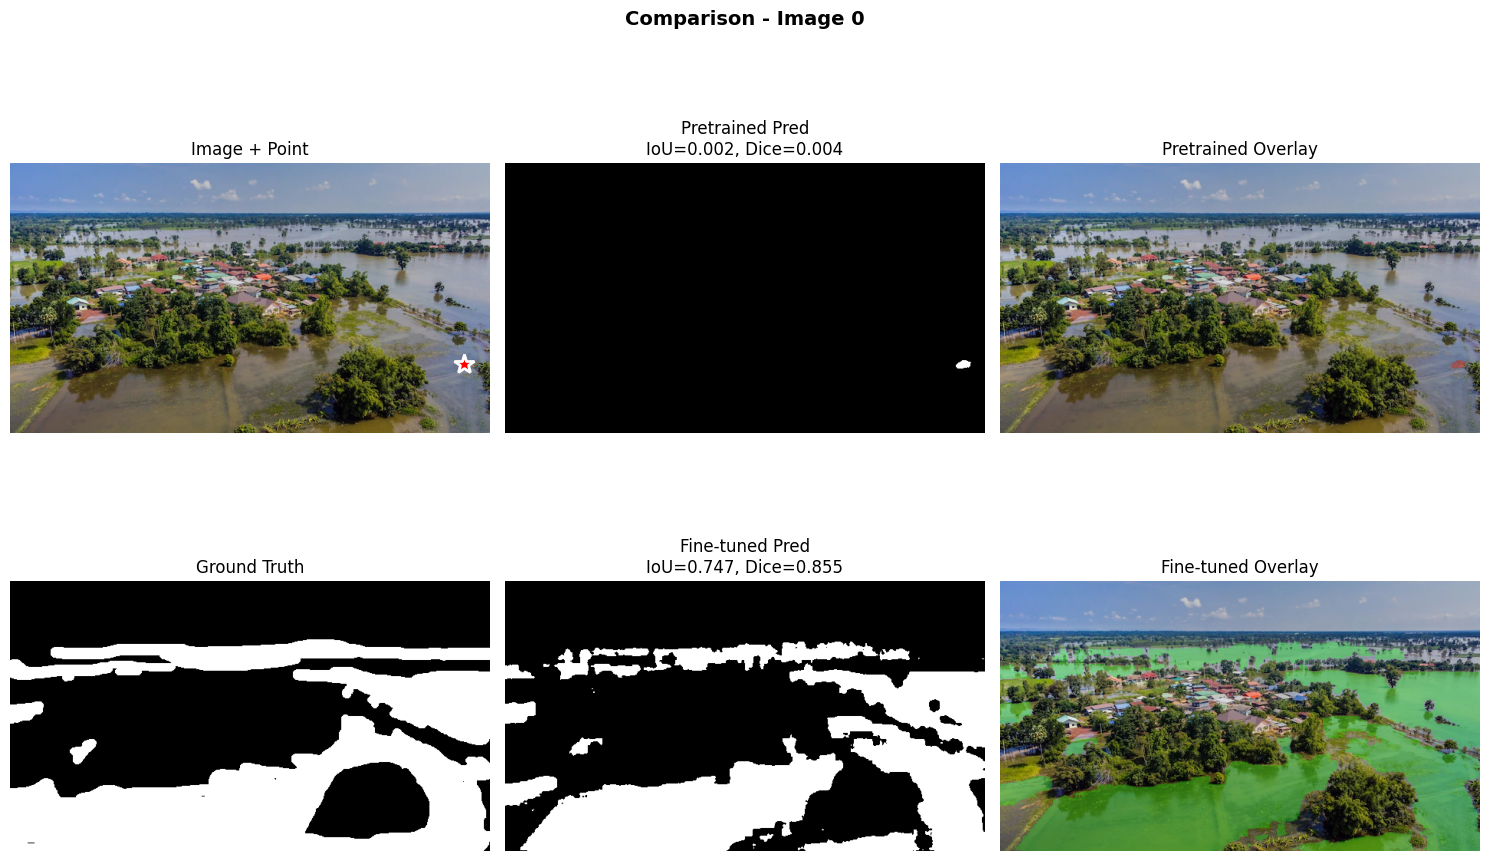

=== IMAGE 0 ===
Pretrained: IoU=0.0018, Dice=0.0036
Fine-tuned: IoU=0.7466, Dice=0.8549
Improvement: IoU +0.7448, Dice +0.8513




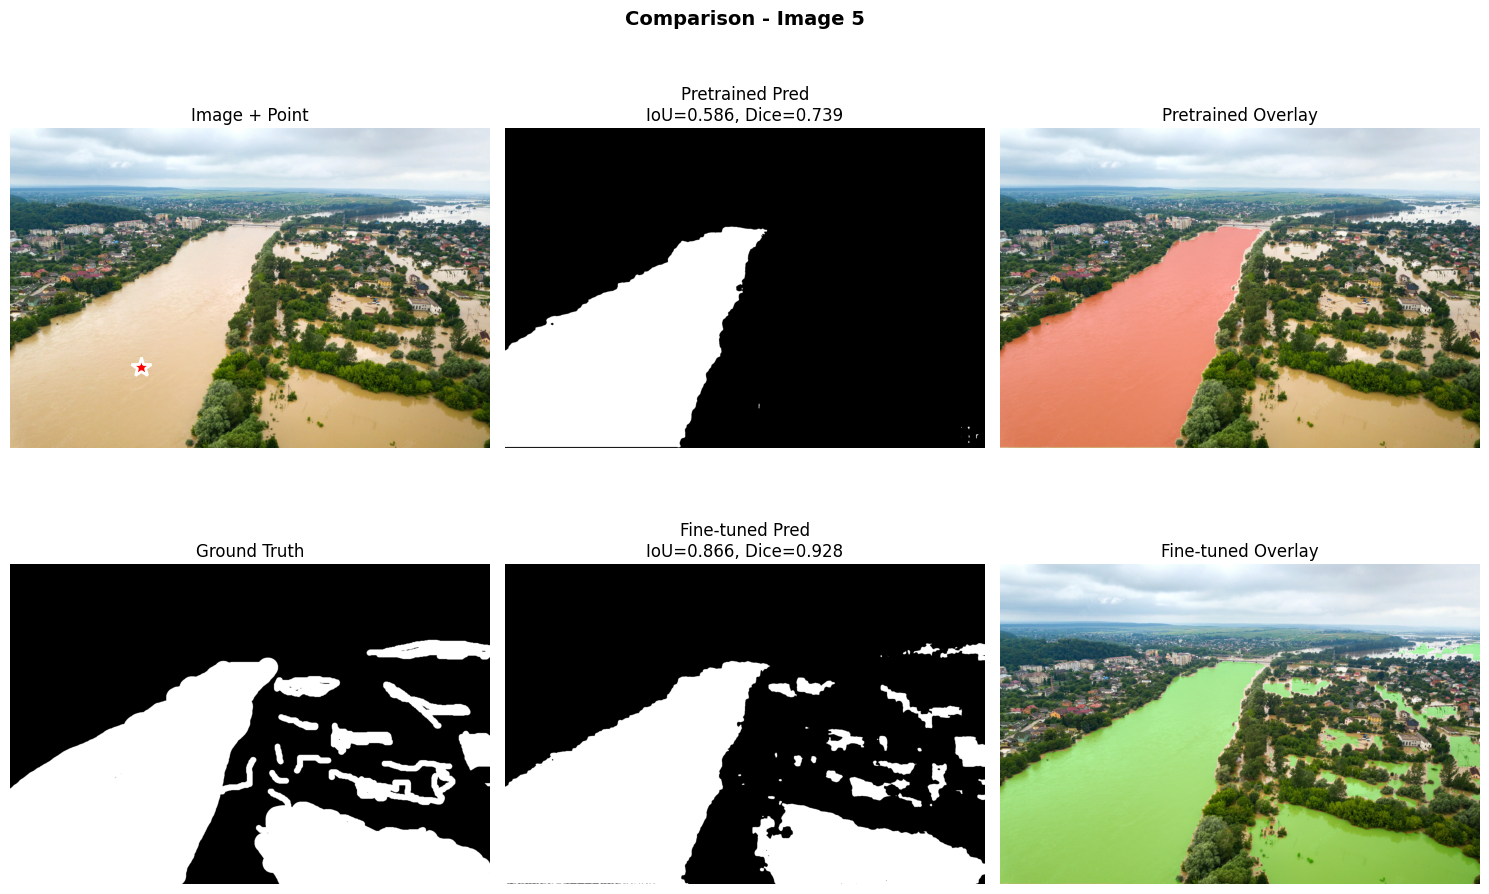

=== IMAGE 5 ===
Pretrained: IoU=0.5862, Dice=0.7391
Fine-tuned: IoU=0.8656, Dice=0.9280
Improvement: IoU +0.2794, Dice +0.1888




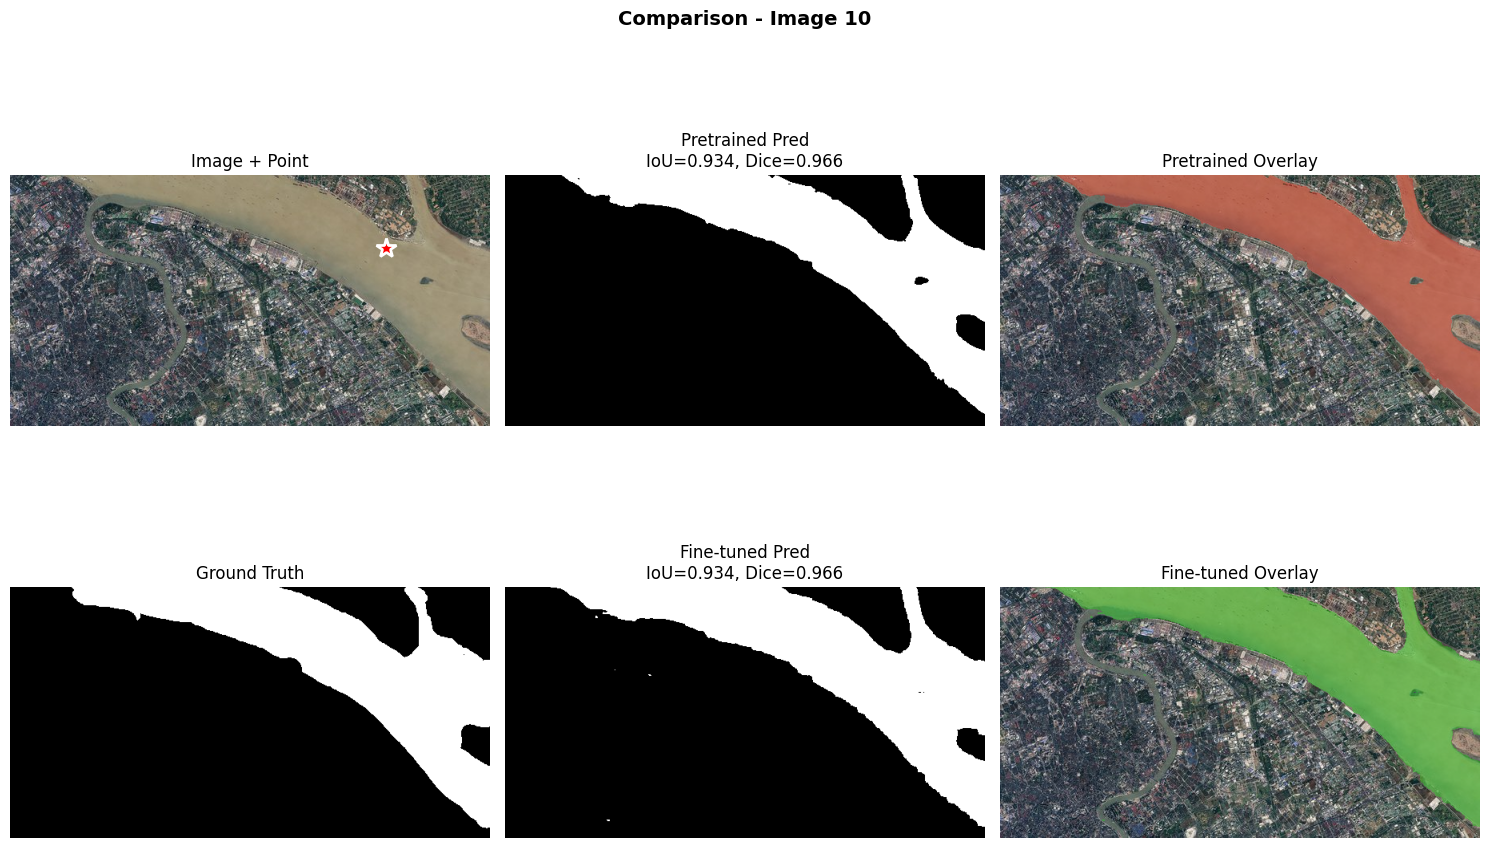

=== IMAGE 10 ===
Pretrained: IoU=0.9338, Dice=0.9658
Fine-tuned: IoU=0.9335, Dice=0.9656
Improvement: IoU +-0.0003, Dice +-0.0001




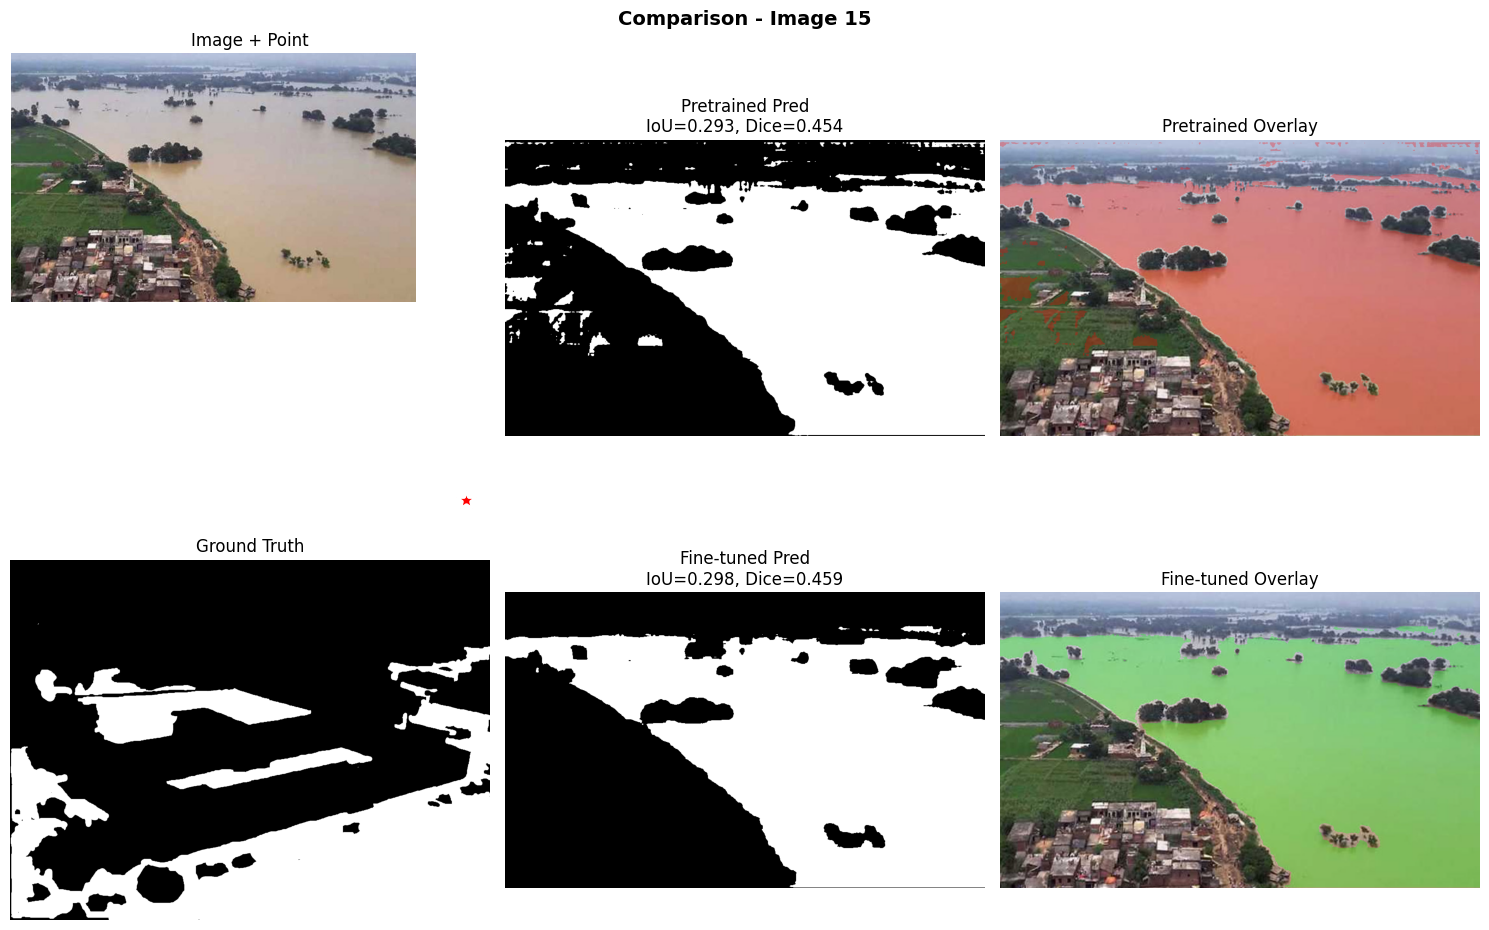

=== IMAGE 15 ===
Pretrained: IoU=0.2934, Dice=0.4537
Fine-tuned: IoU=0.2979, Dice=0.4591
Improvement: IoU +0.0045, Dice +0.0054




In [20]:
# Visualizar mejoras en casos específicos

def visualize_comparison(idx, images, masks, predictor_pre, predictor_ft):
    """
    Visualizar comparación entre pretrained y fine-tuned
    """

    image = images[idx]
    mask_gt = masks[idx]

    # Get center point
    y_coords, x_coords = np.where(mask_gt > 0)
    if len(x_coords) > 0:
        point_x = int(x_coords[len(x_coords) // 2])
        point_y = int(y_coords[len(y_coords) // 2])
    else:
        point_x, point_y = mask_gt.shape[1] // 2, mask_gt.shape[0] // 2

    # Predict with both models
    pred_pre, _ = predict_with_point_prompt(predictor_pre, image, [[point_x, point_y]], [1])
    pred_ft, _ = predict_with_point_prompt(predictor_ft, image, [[point_x, point_y]], [1])

    # Calculate metrics
    iou_pre = calculate_iou(pred_pre, mask_gt)
    iou_ft = calculate_iou(pred_ft, mask_gt)
    dice_pre = calculate_dice(pred_pre, mask_gt)
    dice_ft = calculate_dice(pred_ft, mask_gt)

    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Row 1: Pretrained
    axes[0, 0].imshow(image)
    axes[0, 0].plot(point_x, point_y, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=2)
    axes[0, 0].set_title('Image + Point')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(pred_pre, cmap='gray')
    axes[0, 1].set_title(f'Pretrained Pred\nIoU={iou_pre:.3f}, Dice={dice_pre:.3f}')
    axes[0, 1].axis('off')

    overlay_pre = image.copy()
    overlay_pre[pred_pre > 0] = [255, 0, 0]
    axes[0, 2].imshow(cv2.addWeighted(image, 0.7, overlay_pre, 0.3, 0))
    axes[0, 2].set_title('Pretrained Overlay')
    axes[0, 2].axis('off')

    # Row 2: Fine-tuned
    axes[1, 0].imshow(mask_gt, cmap='gray')
    axes[1, 0].set_title('Ground Truth')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(pred_ft, cmap='gray')
    axes[1, 1].set_title(f'Fine-tuned Pred\nIoU={iou_ft:.3f}, Dice={dice_ft:.3f}')
    axes[1, 1].axis('off')

    overlay_ft = image.copy()
    overlay_ft[pred_ft > 0] = [0, 255, 0]
    axes[1, 2].imshow(cv2.addWeighted(image, 0.7, overlay_ft, 0.3, 0))
    axes[1, 2].set_title('Fine-tuned Overlay')
    axes[1, 2].axis('off')

    plt.suptitle(f'Comparison - Image {idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"=== IMAGE {idx} ===")
    print(f"Pretrained: IoU={iou_pre:.4f}, Dice={dice_pre:.4f}")
    print(f"Fine-tuned: IoU={iou_ft:.4f}, Dice={dice_ft:.4f}")
    print(f"Improvement: IoU +{(iou_ft - iou_pre):.4f}, Dice +{(dice_ft - dice_pre):.4f}")

# Visualizar varios ejemplos
for idx in [0, 5, 10, 15, 20]:
    if idx < len(val_images):
        visualize_comparison(idx, val_images, val_masks, predictor, predictor_finetuned)
        print("\n")

=== ANALYZING PRETRAINED FAILURES ===
Failure cases: 7

Failure statistics:
  Mean IoU: 0.092
  Mean water region width: 1.00 pixels


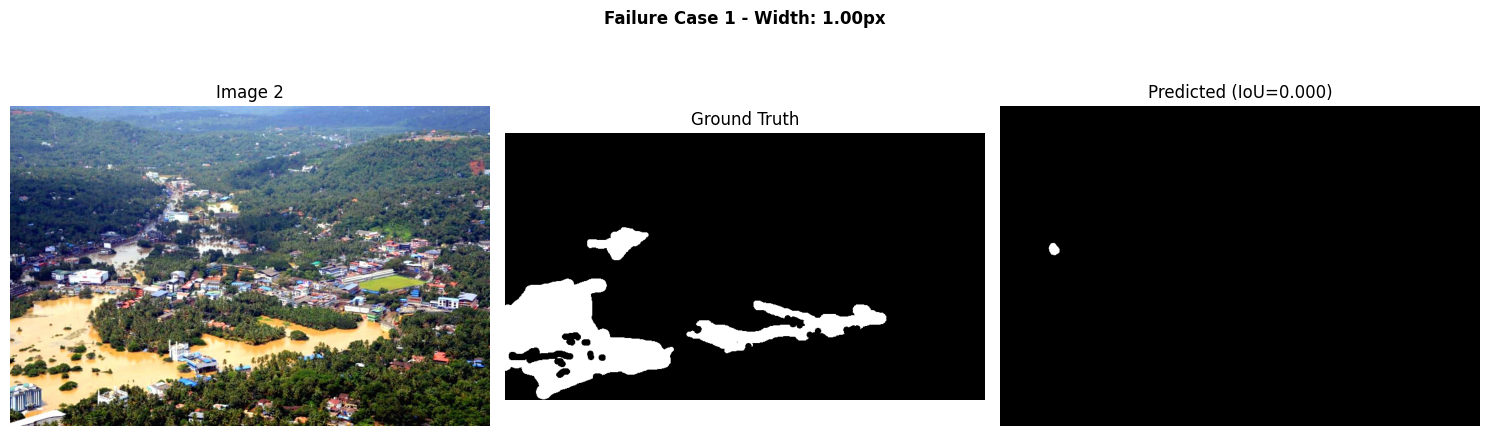

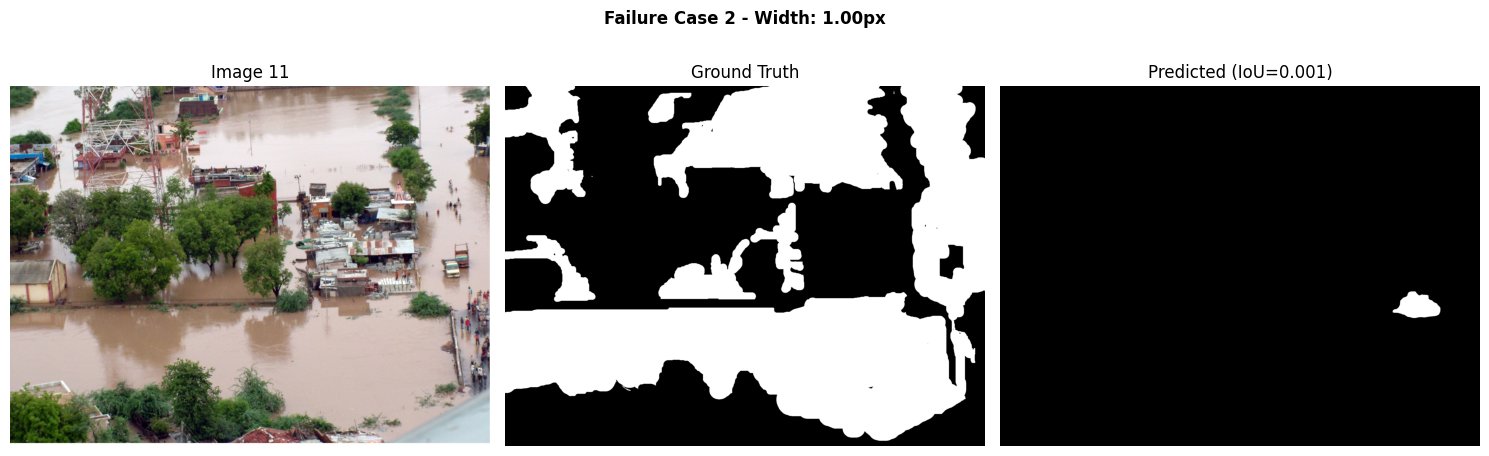

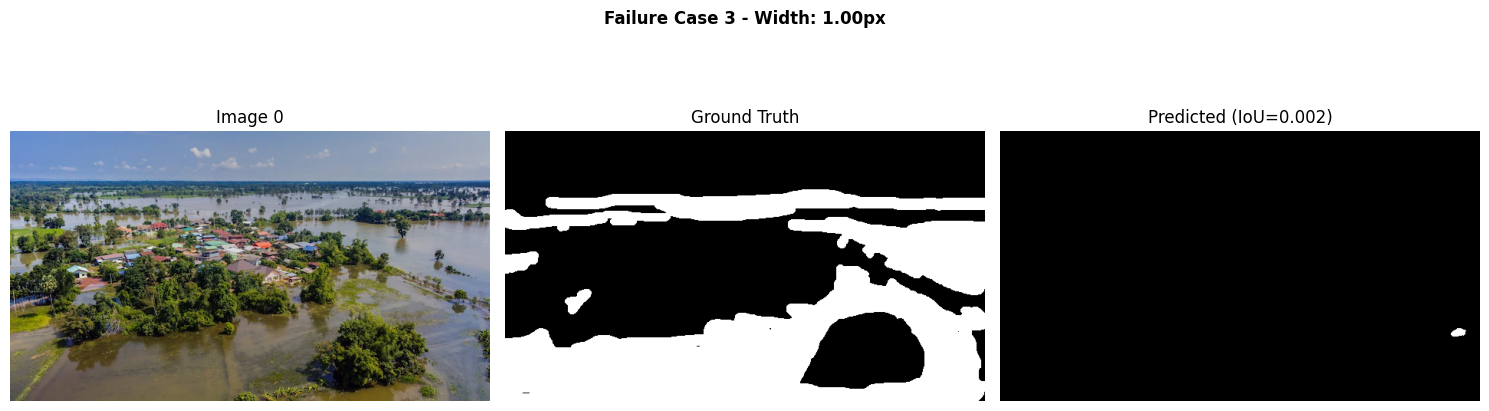


=== ANALYZING FINE-TUNED FAILURES ===
Failure cases: 2

=== FAILURE REDUCTION ===
Pretrained failures: 7
Fine-tuned failures: 2
Reduction: 5 (71.4%)


In [21]:
# Analizar failure cases

def analyze_failure_cases(images, masks, predictor, threshold_iou=0.3):
    """
    Identificar y analizar casos donde el modelo falla
    """

    failure_cases = []

    for i, (image, mask_gt) in enumerate(zip(images, masks)):
        # Get center point
        y_coords, x_coords = np.where(mask_gt > 0)
        if len(x_coords) == 0:
            continue

        point_x = int(x_coords[len(x_coords) // 2])
        point_y = int(y_coords[len(y_coords) // 2])

        # Predict
        pred_mask, _ = predict_with_point_prompt(predictor, image, [[point_x, point_y]], [1])

        # Calculate IoU
        iou = calculate_iou(pred_mask, mask_gt)

        if iou < threshold_iou:
            # Analyze water area characteristics
            crack_area = mask_gt.sum()  # total water pixels
            crack_ratio = crack_area / (mask_gt.shape[0] * mask_gt.shape[1])

            # Estimate water region width (approximate)
            if crack_area > 0:
                crack_length = len(x_coords)
                avg_width = crack_area / crack_length if crack_length > 0 else 0
            else:
                avg_width = 0

            failure_cases.append({
                'idx': i,
                'iou': iou,
                'water_area': crack_area,
                'water_ratio': crack_ratio,
                'avg_width': avg_width,
                'image': image,
                'mask_gt': mask_gt,
                'pred_mask': pred_mask
            })

    return failure_cases

# Analizar failures en pretrained
print("=== ANALYZING PRETRAINED FAILURES ===")
failures_pretrained = analyze_failure_cases(val_images, val_masks, predictor, threshold_iou=0.4)
print(f"Failure cases: {len(failures_pretrained)}")

if len(failures_pretrained) > 0:
    # Estadísticas de failures
    failure_ious = [f['iou'] for f in failures_pretrained]
    failure_widths = [f['avg_width'] for f in failures_pretrained]

    print(f"\nFailure statistics:")
    print(f"  Mean IoU: {np.mean(failure_ious):.3f}")
    print(f"  Mean water region width: {np.mean(failure_widths):.2f} pixels")

    # Visualizar peores casos
    worst_cases = sorted(failures_pretrained, key=lambda x: x['iou'])[:3]

    for i, case in enumerate(worst_cases):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(case['image'])
        axes[0].set_title(f"Image {case['idx']}")
        axes[0].axis('off')

        axes[1].imshow(case['mask_gt'], cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        axes[2].imshow(case['pred_mask'], cmap='gray')
        axes[2].set_title(f"Predicted (IoU={case['iou']:.3f})")
        axes[2].axis('off')

        plt.suptitle(f"Failure Case {i+1} - Width: {case['avg_width']:.2f}px", fontweight='bold')
        plt.tight_layout()
        plt.show()

# Analizar failures en fine-tuned
print("\n=== ANALYZING FINE-TUNED FAILURES ===")
failures_finetuned = analyze_failure_cases(val_images, val_masks, predictor_finetuned, threshold_iou=0.4)
print(f"Failure cases: {len(failures_finetuned)}")

print(f"\n=== FAILURE REDUCTION ===")
print(f"Pretrained failures: {len(failures_pretrained)}")
print(f"Fine-tuned failures: {len(failures_finetuned)}")
print(f"Reduction: {len(failures_pretrained) - len(failures_finetuned)} ({(1 - len(failures_finetuned)/len(failures_pretrained))*100:.1f}%)")